In [54]:
import re

import pandas as pd
import nltk

In [55]:
comments = pd.read_csv(r'C:\Users\udit sharma\Desktop\MSA\sentiment-analysis-msa-phase-2\Comments1_.csv')

<centre><h1>Sentiment Analysis</h1> </centre>

<h2>1. Using prebuilt packages</h2>

<h3>Data cleaning and exploration</h3>

In [7]:
sample = comments.Reply.iloc[10]
sample

"Aunt jemina has a black person. That's racial #;eoa.        \nEdit: sorry jemima*"

In [8]:
re.sub(r'\(?http\S+', '', sample)

"Aunt jemina has a black person. That's racial #;eoa.        \nEdit: sorry jemima*"

Getting rid of \n, \t... etc characters that does not help with prediction but might link 2 words together and make them indistinguishable from one another

In [9]:
sample = comments.Reply.iloc[9]
sample

"It's Evolution, just backwards."

In [10]:
word_tokenized = nltk.word_tokenize(sample)
word_tokenized

['It', "'s", 'Evolution', ',', 'just', 'backwards', '.']

In [11]:
' '.join(word_tokenized)

"It 's Evolution , just backwards ."

#### Bigrams

In [12]:
sample = ['more', 'is', 'said', 'than', 'done', 'is', 'said', 'than']

In [13]:
from nltk.collocations import *

bigram_measures = nltk.collocations.BigramAssocMeasures()

finder = BigramCollocationFinder.from_words(sample)

# only bigrams that appear 2+ times
finder.apply_freq_filter(2) 

# return the 10 n-grams with the highest PMI
print (finder.nbest(bigram_measures.pmi, 10) )

[('is', 'said'), ('said', 'than')]


Let's try it on first 10000 rows of our text

In [14]:
all_text = comments.iloc[:10000,:].Reply.str.cat(sep='. ')

In [15]:
all_text = nltk.word_tokenize(all_text)

In [16]:
def common_bigrams(tokenized_text, min_freq, top_n):
    bigram_measures = nltk.collocations.BigramAssocMeasures()
    finder = BigramCollocationFinder.from_words(tokenized_text)
    finder.apply_freq_filter(min_freq) 
    finder.nbest(bigram_measures.pmi, top_n)
    return finder.nbest(bigram_measures.pmi, top_n)

print(common_bigrams(all_text, 10, 10))

[('Advocating', 'Harm'), ('echo', 'chamber'), ('Lives', 'Matter'), ('blah', 'blah'), ('minimum', 'wage'), ('tolerate', 'advocating'), ('United', 'States'), ('New', 'York'), ('nursing', 'homes'), ('George', 'Floyd')]


#### Wordcloud

In [20]:
import wordcloud
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

sample = comments.iloc[:10000,:].Reply.str.cat(sep='. ')

In [21]:
import random
def grey_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return "hsl(0, 0%%, %d%%)" % random.randint(1, 20)

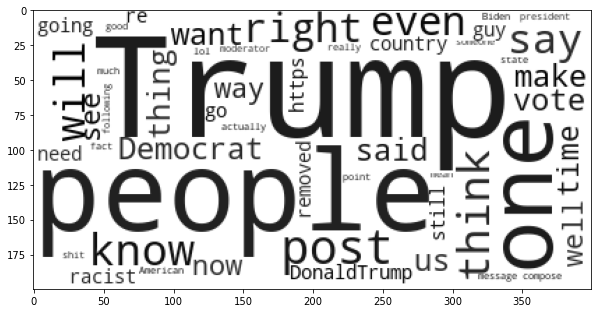

In [22]:
stp = STOPWORDS.copy()
wc = WordCloud(background_color="white", max_words=50,  stopwords=stp)
# generate word cloud
wc.generate(sample)

plt.figure(figsize=(10,20))
plt.imshow(wc.recolor(color_func=grey_color_func, random_state=3))
plt.show()

- ### __Vader and Textblob__

Vader package first

In [24]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer, VaderConstants

#FIRST, we initialize VADER so we can use it within our Python script
sid = SentimentIntensityAnalyzer()

We can add sentiment scores to words manually if we want

In [25]:
new_words = {
    'hello': -1000,
}

sid.lexicon.update(new_words)

In [26]:
sid.polarity_scores('hello there')

{'neg': 0.999, 'neu': 0.001, 'pos': 0.0, 'compound': -1.0}

In [27]:
#As this is for demonstration purposes only - instead of doing the scoring over 200,000+ rows, we will use a subset
df = comments[comments.Key<101]
df.shape

(19416, 4)

In [28]:
#The cleaning steps as outlined earlier
df.Reply = df.Reply.apply(lambda x: re.sub(r'\(?http\S+', '', x))
df.Reply = df.Reply.apply(lambda x: ' '.join(nltk.word_tokenize(x)))

c:\users\udit sharma\appdata\local\programs\python\python38-32\lib\site-packages\pandas\core\generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [29]:
df[['neg','neu','pos','compound']] = df.Reply.apply(lambda x: pd.Series(sid.polarity_scores(x)))

c:\users\udit sharma\appdata\local\programs\python\python38-32\lib\site-packages\pandas\core\frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [30]:
df.head(3)

,Reply,Upvote,Time,Key,neg,neu,pos,compound
0,This subreddit is a pro-Trump subreddit for sh...,1,2020-09-12 01:22:08,1,0.077,0.821,0.103,0.3948
1,Good one . I laughed out loud,59,2020-09-12 02:06:40,1,0.000,0.337,0.663,0.7096
2,"Also butter . Got rid of the native girl , kep...",29,2020-09-12 04:11:04,1,0.000,1.000,0.000,0.0000


Textblob package now

In [33]:
from textblob.sentiments import NaiveBayesAnalyzer, PatternAnalyzer
from textblob import Blobber
tba = Blobber(analyzer=NaiveBayesAnalyzer())

In [34]:
tba('My life is a frictionless slide downhill').sentiment

Sentiment(classification='neg', p_pos=0.374939442175929, p_neg=0.6250605578240714)

In [35]:
#As this is for demonstration purposes only - we will only use a subset
df = comments[comments.Key<101]

In [36]:
#The cleaning steps as outlined earlier
df.Reply = df.Reply.apply(lambda x: re.sub(r'\(?http\S+', '', x))
df.Reply = df.Reply.apply(lambda x: ' '.join(nltk.word_tokenize(x)))

c:\users\udit sharma\appdata\local\programs\python\python38-32\lib\site-packages\pandas\core\generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [37]:
df[['Classification','positive','negative']] = df.Reply.apply(lambda x: pd.Series({'Classification':tba(x).sentiment[0],
                                                                        'positive':tba(x).sentiment[1],
                                                                        'negative':tba(x).sentiment[2]}))

c:\users\udit sharma\appdata\local\programs\python\python38-32\lib\site-packages\pandas\core\frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [38]:
df.head(3)

,Reply,Upvote,Time,Key,Classification,positive,negative
0,This subreddit is a pro-Trump subreddit for sh...,1,2020-09-12 01:22:08,1,pos,0.998597,0.001403
1,Good one . I laughed out loud,59,2020-09-12 02:06:40,1,neg,0.245317,0.754683
2,"Also butter . Got rid of the native girl , kep...",29,2020-09-12 04:11:04,1,pos,0.819397,0.180603


## __2.__ __Training your own classifier__

 - ### __Preprocessing__

In [40]:
data = pd.read_csv(r'C:\Users\udit sharma\Desktop\MSA\sentiment-analysis-msa-phase-2\train.csv')

In [41]:
data.head(1)

,textID,text,sentiment
0,cb774db0d1,"I`d have responded, if I were going",neutral


In [42]:
data.dropna(subset=['text'], inplace=True)

Remove punctuation

In [43]:
data.text = data.text.apply(lambda x: re.sub(r'[^\w\s]', '', x) )

Remove stopwords

In [44]:
from nltk.corpus import stopwords
stopwords = stopwords.words('english')
data.text = data.text.apply(lambda x: ' '.join([word for word in nltk.word_tokenize(x) if word.lower() not in stopwords]))

Remove links

In [45]:
data.text = data.text.apply(lambda x: re.sub(r'\(?http\S+', '', x))

Stemming and Lemmatization

In [46]:
from nltk.stem import PorterStemmer
porter_stemmer = PorterStemmer()

In [47]:
text = nltk.word_tokenize('women run running runs ran')
stemmed = [porter_stemmer.stem(word) for word in text]
stemmed

['women', 'run', 'run', 'run', 'ran']

In [48]:
lemmatizer = nltk.WordNetLemmatizer()
lemmatized = [lemmatizer.lemmatize(word) for word in text]
lemmatized

['woman', 'run', 'running', 'run', 'ran']

In [49]:
data.text = data.text.apply(lambda x: ' '.join(
    [lemmatizer.lemmatize(word) for word in nltk.word_tokenize(x)]
        ) )

 - ### __Training a naive bayes sentiment classifier__

In [50]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn import metrics

We use CountVectorizer to help us create a matrix for machine learning

In [51]:
vectorizer = CountVectorizer()

In [52]:
data.dropna(subset=['text'], inplace=True)
X = vectorizer.fit_transform(data.text)

We instantiate a multinomial naive bayes model, then fit it

In [53]:
nb = MultinomialNB()

#nb.fit(features_matrix, item_we_want_to_predict)
nb.fit(X, data.sentiment)

MultinomialNB()